## With this homework, I practiced building multiple models on the command-line
#### - (1) Use multi-omics data from human cancer cell lines from the CCLE and GDSC databases. 
#### - (2) Build the models on the CCLE dataset and evaluate the models on the GDSC dataset. 
#### - (3) Benchmarking of different deep learning architectures and different combinations of omic data modalities used as input.
#### - (4) This jupyter notebook explores the best performing models. 

In [2]:
import os
import glob
import flexynesis
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import math
import random
import lightning as pl
from flexynesis import plot_dim_reduced
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display

#### Download and unpack the data: https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/ccle_vs_gdsc.tgz

In [3]:
if not os.path.exists("ccle_vs_gdsc"):
    !wget -O ccle_vs_gdsc.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/ccle_vs_gdsc.tgz" && tar -xzvf ccle_vs_gdsc.tgz

### Use flexynesis on the command-line to predict drug responses for “Erlotinib”. Write a bash script to run the following experiments: Try a combination of:

a) different architectures: e.g. DirectPred, Supervised VAE, GNN (Test at least 2 of these).

b) data type combinations (e.g. mutation, mutation + rna, mutation + cnv) (Test at least 2 of these)

c) fusion methods: early, intermediate (applies only to tools other than GNN)

So, in total, you will run maximally 3 x 3 x 2 = 18 different flexynesis runs (and minimally 2 x 2 x 2 = 8 different runs).

Note: GNNs actually only support "early" fusion, so you can skip "intermediate" fusion for GNNs, but you can try different graph convolution options for GNNs. For GNNs, try "GC" and "SAGE" as different options in your experiment (See --gnn_conv_type argument).

Hint 1: Restrict your analysis to 5-10% of the features (use a combination of variance and laplacian score filtering).

Hint 2: It is okay to use few HPO iterations for this exercise (e.g. 15 iterations or so) (considering the resourse/time limits etc). The point of this exercise is not to find the perfect model, but to get an insight on the idea of benchmarking different setups.


In [4]:
data_importer = flexynesis.DataImporter(path ='ccle_vs_gdsc', 
                                        data_types = ['mutation', 'rna', 'cnv'], log_transform=False, 
                                        concatenate=False, top_percentile=10, min_features=1000,
                                       variance_threshold=0.5)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ccle_vs_gdsc/train/rna.csv...
[INFO] Importing ccle_vs_gdsc/train/clin.csv...
[INFO] Importing ccle_vs_gdsc/train/cnv.csv...
[INFO] Importing ccle_vs_gdsc/train/mutation.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ccle_vs_gdsc/test/rna.csv...
[INFO] Importing ccle_vs_gdsc/test/clin.csv...
[INFO] Importing ccle_vs_gdsc/test/cnv.csv...
[INFO] Importing ccle_vs_gdsc/test/mutation.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 

[WARNING] Warnings:

[WARNING] 1. Warning: Some sample labels in train/clin.csv are missing in train/rna.csv: {'NCI-H2073', 'OE21', 'MUTZ-3', 'SF8657', 'GLC-82', 'HN', 'M059J', 'KP-1NL', 'JHUEM-7', 'SNU-C2B', 'BGC-823', 'DOV13', 'HRT-18', 'COLO 699', 'ACCS', 'KP-1N'}
[WARNING] 2. Warning: Some sample labels in train/c

Filtering redundant features: 100%|███████| 1000/1000 [00:00<00:00, 2934.48it/s]


[INFO] Implementing feature selection using laplacian score for layer: cnv with  11304 features  and  935  samples 


Filtering redundant features: 100%|██████| 1130/1130 [00:00<00:00, 63468.36it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mutation
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 1  # of rows: 1
[INFO] Number of NA values:  0
[INFO] DataFrame mutation - Removed 41 features.

[INFO] working on layer:  rna
[INFO] Number of NA values:  0
[INFO] DataFrame rna - Removed 5824 features.

[INFO] working on layer:  cnv
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 19540  # of rows: 329
[INFO] Number of NA values:  0
[INFO] DataFrame cnv - Removed 11634 features.
[INFO] DataFrame mutation - Removed 61 samples (8.63%).
[INFO] DataFrame rna - Removed 53 samples (7.29%).
[INFO] DataFrame cnv - Removed 56 samples (5.79%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data

### Exploratory Data Analysis 

In [5]:
train_dataset.dat, test_dataset.dat

({'rna': tensor([[-0.5364, -0.3522, -0.5043,  ..., -0.2175, -0.3669,  0.9765],
          [ 4.2816, -0.3330,  0.6085,  ..., -0.0532, -0.0955,  1.7404],
          [-0.1710, -0.1475, -0.4078,  ..., -0.2049, -0.4005, -0.6274],
          ...,
          [-0.2384,  1.6414,  2.3472,  ..., -0.2419,  0.0108,  2.0368],
          [-0.3045, -0.3505, -0.5019,  ..., -0.2191,  0.1627, -0.5986],
          [-0.3937, -0.1477, -0.5598,  ..., -0.1489, -0.1923,  0.2754]]),
  'cnv': tensor([[ 5.8669e-01,  1.4175e+00, -3.7561e-01,  ..., -1.0927e+00,
            1.3485e+00, -1.0875e+00],
          [ 8.4856e-01,  2.5571e+00,  9.4763e-01,  ..., -3.1725e-01,
            2.6664e+00, -3.1949e-01],
          [-1.4164e-01, -2.6268e+00,  1.3680e-02,  ..., -6.4494e-01,
           -2.6282e+00, -6.4404e-01],
          ...,
          [-8.5032e-01, -8.2824e-01, -8.6441e-01,  ..., -4.6583e-01,
           -8.2599e-01, -4.6665e-01],
          [-4.4770e-01, -3.0063e-01, -4.3497e-01,  ...,  2.2976e-03,
           -3.1514e-01, -

In [6]:
train_dataset.dat['mutation'].shape, train_dataset.dat['cnv'].shape, train_dataset.dat['rna'].shape

(torch.Size([935, 24]), torch.Size([935, 989]), torch.Size([935, 689]))

In [7]:
test_dataset.dat['mutation'].shape, test_dataset.dat['cnv'].shape, test_dataset.dat['rna'].shape

(torch.Size([560, 24]), torch.Size([560, 989]), torch.Size([560, 689]))

In [8]:
train_dataset.samples[1:20], train_dataset.features

(['SK-MEL-31',
  'Lu-99A',
  'SNU-738',
  'SF295',
  '697',
  'Kasumi-2',
  '786-O',
  'Hs 294T',
  'U2OS',
  'DU4475',
  'Hs 737.T',
  'KMS-26',
  'CMK-11-5',
  'Hs 578T',
  'JHOM-1',
  'NCI-H146',
  'SK-N-FI',
  'ZR-75-1',
  'NCI-H2170'],
 {'rna': Index(['SOX10', 'TNFRSF17', 'CD53', 'TCL1A', 'CD19', 'VPREB3', 'MLANA',
         'LGALS4', 'YAP1', 'BTK',
         ...
         'S100B', 'IKZF1', 'TYR', 'RAB25', 'PMEL', 'SLC45A2', 'SCG3', 'AZU1',
         'RAG1', 'HLA-DRA'],
        dtype='object', length=689),
  'cnv': Index(['GNAS-AS1', 'SNORA22', 'LINC01260', 'LUZP6', 'POLR2J2', 'HCK', 'NUPL2',
         'KIAA0586', 'RNASEH2C', 'ANKRD9',
         ...
         'PRSS58', 'GCH1', 'MIR4308', 'PLD4', 'AHNAK2', 'SUGCT', 'GPR68',
         'ITPK1', 'ZNHIT1', 'CCDC88C'],
        dtype='object', length=989),
  'mutation': Index(['APC', 'BRAF', 'CDH1', 'CDKN2A', 'CTNNB1', 'EGFR', 'FBXW7', 'KDM6A',
         'KRAS', 'MAP2K4', 'MLH1', 'MSH2', 'NF1', 'NF2', 'NOTCH1', 'NRAS',
         'PIK3CA', 'PIK3R1'

In [9]:
test_dataset.samples[1:20], test_dataset.features

(['Lu-99A',
  'SNU-475',
  'SF295',
  '697',
  '786-O',
  'DU4475',
  'ETK-1',
  'Hs 578T',
  'SK-N-FI',
  'NCI-H2170',
  'COLO 800',
  'NCI-H226',
  'LB2241-RCC',
  'NCI-H526',
  'SJNB-14',
  'SNU-449',
  'CAL-51',
  'Loucy',
  'D-566MG'],
 {'rna': Index(['SOX10', 'TNFRSF17', 'CD53', 'TCL1A', 'CD19', 'VPREB3', 'MLANA',
         'LGALS4', 'YAP1', 'BTK',
         ...
         'S100B', 'IKZF1', 'TYR', 'RAB25', 'PMEL', 'SLC45A2', 'SCG3', 'AZU1',
         'RAG1', 'HLA-DRA'],
        dtype='object', length=689),
  'cnv': Index(['GNAS-AS1', 'SNORA22', 'LINC01260', 'LUZP6', 'POLR2J2', 'HCK', 'NUPL2',
         'KIAA0586', 'RNASEH2C', 'ANKRD9',
         ...
         'PRSS58', 'GCH1', 'MIR4308', 'PLD4', 'AHNAK2', 'SUGCT', 'GPR68',
         'ITPK1', 'ZNHIT1', 'CCDC88C'],
        dtype='object', length=989),
  'mutation': Index(['APC', 'BRAF', 'CDH1', 'CDKN2A', 'CTNNB1', 'EGFR', 'FBXW7', 'KDM6A',
         'KRAS', 'MAP2K4', 'MLH1', 'MSH2', 'NF1', 'NF2', 'NOTCH1', 'NRAS',
         'PIK3CA', 'PIK3R1'

In [10]:
train_dataset.ann

{'Crizotinib': tensor([       nan, 2.5789e-02, 1.3932e-01,        nan, 1.1950e-01, 1.5911e-01,
         3.8256e-02, 2.1169e-02, 7.4971e-02, 4.0625e-02,        nan,        nan,
         1.3795e-01,        nan, 2.8771e-02,        nan,        nan, 1.0044e-02,
         0.0000e+00, 4.2340e-02,        nan, 1.7467e-01,        nan, 3.8909e-02,
                nan,        nan,        nan,        nan, 1.2830e-02, 1.8443e-01,
                nan,        nan,        nan, 7.1612e-02, 5.4863e-02, 1.4854e-01,
         1.9596e-02, 7.0945e-02, 5.0374e-02,        nan,        nan, 4.5768e-02,
                nan, 3.7980e-02, 4.2579e-02,        nan, 1.3735e-02, 1.0550e-02,
         2.6741e-02, 2.2438e-02,        nan,        nan, 6.3165e-02, 0.0000e+00,
                nan,        nan, 5.8767e-02, 5.3985e-02,        nan, 1.0407e-01,
         1.5148e-02, 2.3456e-02,        nan,        nan,        nan, 1.1192e-01,
         6.8732e-02, 9.4732e-02, 1.9549e-02, 1.1473e-02, 2.3679e-02,        nan,
         5.509

In [11]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: Crizotinib
Numerical Variable Summary: Median = 0.0348820359866738, Mean = 0.05367918925271896
------
Summary for variable: Dovitinib
Numerical Variable Summary: Median = 0.0747548468378515, Mean = 0.08868079986988006
------
Summary for variable: Erlotinib
Numerical Variable Summary: Median = 0.0401425137728223, Mean = 0.06560994516154506
------
Summary for variable: Irinotecan
Numerical Variable Summary: Median = 0.3920620379485415, Mean = 0.38968231036548984
------
Summary for variable: L-685458
Numerical Variable Summary: Median = 0.0144951759575499, Mean = 0.030708233328112813
------
Summary for variable: Lapatinib
Numerical Variable Summary: Median = 0.0390705370047462, Mean = 0.06683012778667083
------
Summary for variable: LBW242
Numerical Variable Summary: Median = 0.0547794573417837, Mean = 0.07822785863411183
------
Summary for variable: Nilotinib
Numerical Variable Summary: Median = 0.0296334712782784, Mean = 0.0512712547926707
------
Summary for variab

In [12]:
flexynesis.print_summary_stats(test_dataset)

Summary for variable: (2R,6aS,12aS)-2-Isopropyl-8,9-dimethoxy-1,2,12,12a-tetrahydrochromeno[3,4-b]furo[2,3-h]chromen-6(6aH)-one
Numerical Variable Summary: Median = 0.137673879066792, Mean = 0.15921163001570104
------
Summary for variable: (5R,5aR,8aR)-9-Bromo-5-(3,4,5-trimethoxyphenyl)-5,8,8a,9-tetrahydrofuro[3',4':6,7]naphtho[2,3-d][1,3]dioxol-6(5aH)-one
Numerical Variable Summary: Median = 0.192777551603734, Mean = 0.19435297125740514
------
Summary for variable: 1,3-Bis(2-chloroethyl)-1-nitrosourea
Numerical Variable Summary: Median = 0.0082343323580145, Mean = 0.020375774403069216
------
Summary for variable: 2-fluoroAraA (fludarabine)
Numerical Variable Summary: Median = 0.0321679832898623, Mean = 0.07052042918700793
------
Summary for variable: 2-Pyridinecarboxylic acid
Numerical Variable Summary: Median = 0.03230051266080725, Mean = 0.03717847227732785
------
Summary for variable: 2H-Indol-2-one, 3,3-bis[4-(acetyloxy)phenyl]-1,3-dihydro-
Numerical Variable Summary: Median = 0.0

In [13]:
train_dataset.label_mappings, test_dataset.label_mappings

({'tissueid': {0: 'Ampulla of Vater',
   1: 'Biliary Tract',
   2: 'Bladder/Urinary Tract',
   3: 'Bone',
   4: 'Bowel',
   5: 'Breast',
   6: 'CNS/Brain',
   7: 'Esophagus/Stomach',
   8: 'Head and Neck',
   9: 'Kidney',
   10: 'Liver',
   11: 'Lung',
   12: 'Lymphoid',
   13: 'Myeloid',
   14: 'Other',
   15: 'Ovary/Fallopian Tube',
   16: 'Pancreas',
   17: 'Peripheral Nervous System',
   18: 'Pleura',
   19: 'Prostate',
   20: 'Skin',
   21: 'Soft Tissue',
   22: 'Thyroid',
   23: 'Uterus'}},
 {'tissueid': {0: 'Ampulla of Vater',
   1: 'Biliary Tract',
   2: 'Bladder/Urinary Tract',
   3: 'Bone',
   4: 'Bowel',
   5: 'Breast',
   6: 'CNS/Brain',
   7: 'Esophagus/Stomach',
   8: 'Head and Neck',
   9: 'Kidney',
   10: 'Liver',
   11: 'Lung',
   12: 'Lymphoid',
   13: 'Myeloid',
   14: 'Other',
   15: 'Ovary/Fallopian Tube',
   16: 'Pancreas',
   17: 'Peripheral Nervous System',
   18: 'Pleura',
   19: 'Prostate',
   20: 'Skin',
   21: 'Soft Tissue',
   22: 'Thyroid',
   23: 'Uterus'

In [14]:
Erlotinib_vals = train_dataset.ann["Erlotinib"][:10]
mapping = train_dataset.label_mappings["tissueid"]
df = pd.DataFrame({
    "STUDY": Erlotinib_vals.tolist(),
    "Mapped Label": [
        mapping[int(x.item())] if not math.isnan(x.item()) else "NaN"
        for x in Erlotinib_vals
    ]
})
display(df)

,STUDY,Mapped Label
0,NaN,NaN
1,0.022938,Ampulla of Vater
2,0.093511,Ampulla of Vater
3,NaN,NaN
4,0.054866,Ampulla of Vater
5,0.109439,Ampulla of Vater
6,0.051474,Ampulla of Vater
7,0.017400,Ampulla of Vater
8,0.031624,Ampulla of Vater
9,0.044937,Ampulla of Vater


In [15]:
df = pd.DataFrame(train_dataset.dat['mutation'], index = train_dataset.samples, columns= train_dataset.features['mutation'])

In [16]:
df.head()

,APC,BRAF,CDH1,CDKN2A,CTNNB1,EGFR,FBXW7,KDM6A,KRAS,MAP2K4,...,NOTCH1,NRAS,PIK3CA,PIK3R1,PTEN,RB1,SMAD4,SMARCA4,STK11,TP53
NCI-H596,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,-0.471405,-0.165748,...,-0.27107,-0.264186,2.842124,-0.185181,-0.363265,3.291723,-0.240192,-0.314177,-0.16231,0.757677
SK-MEL-31,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,-0.471405,-0.165748,...,-0.27107,-0.264186,-0.351849,-0.185181,-0.363265,-0.303792,-0.240192,-0.314177,-0.16231,0.757677
Lu-99A,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,2.121320,-0.165748,...,-0.27107,-0.264186,2.842124,-0.185181,-0.363265,-0.303792,-0.240192,-0.314177,-0.16231,-1.319824
SNU-738,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,-0.471405,6.033241,...,-0.27107,-0.264186,-0.351849,-0.185181,-0.363265,-0.303792,4.163332,3.182916,-0.16231,0.757677
SF295,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,-0.471405,-0.165748,...,-0.27107,-0.264186,-0.351849,-0.185181,2.752813,-0.303792,-0.240192,-0.314177,-0.16231,0.757677


In [17]:
ds = train_dataset

In [18]:
f = 'tissueid'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] 

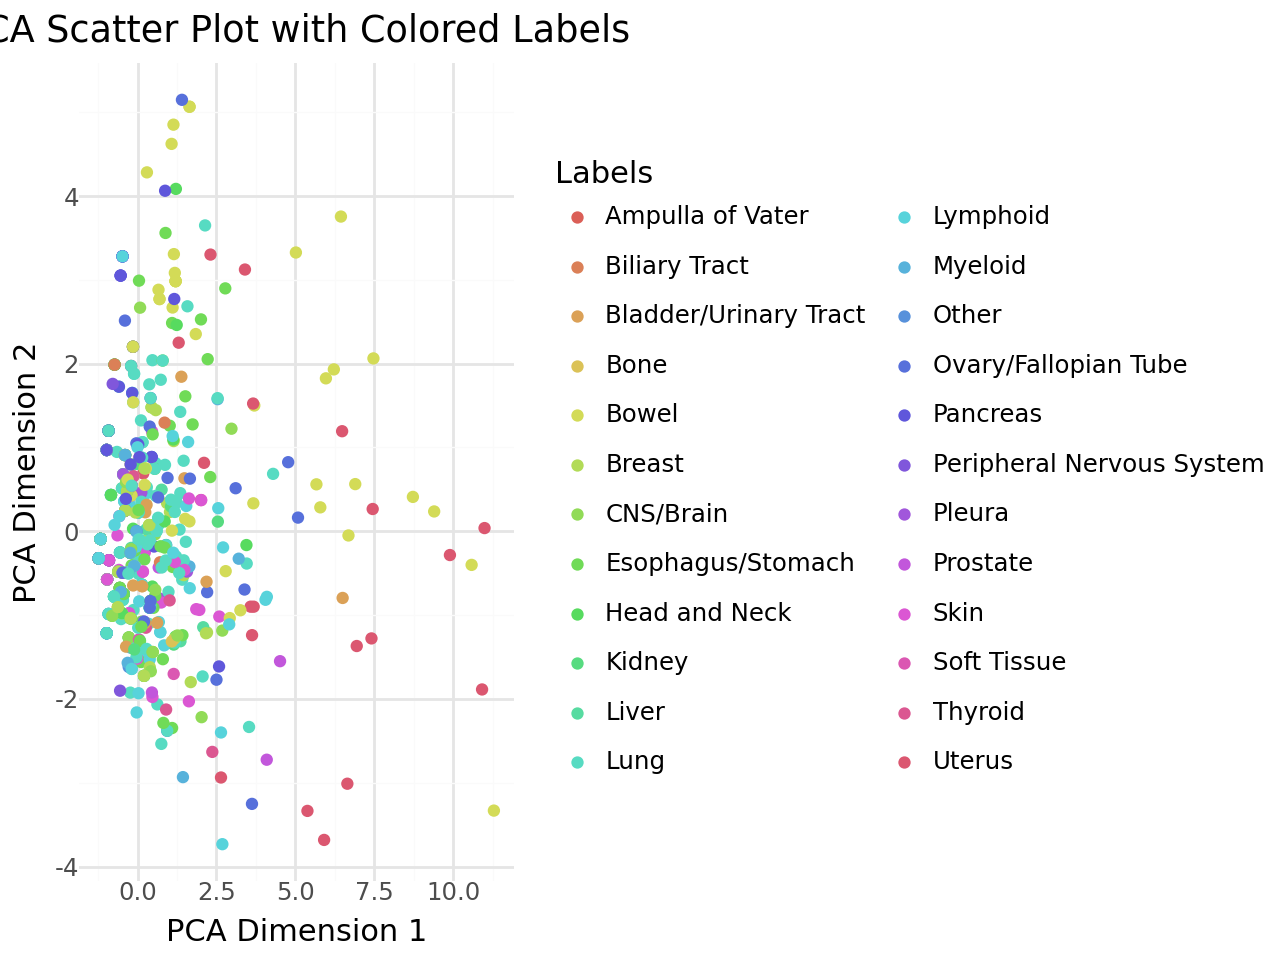

In [19]:
flexynesis.plot_dim_reduced(df, labels, color_type = 'categorical', method='pca')

In [20]:
train_dataset.ann.keys()

dict_keys(['Crizotinib', 'Dovitinib', 'Erlotinib', 'Irinotecan', 'L-685458', 'Lapatinib', 'LBW242', 'Nilotinib', 'Nutlin-3', 'Nvp-aew541', 'Nvp-tae 684', 'Paclitaxel', 'Palbociclib', 'Panobinostat', 'PD-0325901', 'Pha-665752', 'PLX4720', 'Raf265(chir-265)', 'Saracatinib', 'Selumetinib', 'Sorafenib', 'Tanespimycin', 'Topotecan', 'Vandetanib', 'tissueid'])

In [21]:
# List available clinical variables in the training dataset (from .ann)
clinical_vars = ['Erlotinib', 'Crizotinib', 'Paclitaxel', 'Tanespimycin']

# Prepare the data matrices for CNV, RNA, and MUT
ds = train_dataset
df_cnv = pd.DataFrame(ds.dat["cnv"], index=ds.samples, columns=ds.features["cnv"])
df_mut = pd.DataFrame(ds.dat["mutation"], index=ds.samples, columns=ds.features["mutation"])
df_rna = pd.DataFrame(ds.dat["rna"], index=ds.samples, columns=ds.features["rna"])

def get_labels(variable):
    """
    For a given clinical variable, returns a tuple:
      (labels, color_type)
    If a mapping exists, labels are mapped (categorical);
    otherwise, raw values are returned (numerical).
    """
    vals = ds.ann[variable].numpy()
    if variable in ds.label_mappings:
        labels = [ds.label_mappings[variable][int(x.item())] if not math.isnan(x.item()) else "NaN" 
                  for x in ds.ann[variable]]
        color_type = "categorical"
    else:
        labels = vals  # Use raw numeric values
        color_type = "numerical"
    return labels, color_type

PCA plot for CNV data colored by: Erlotinib


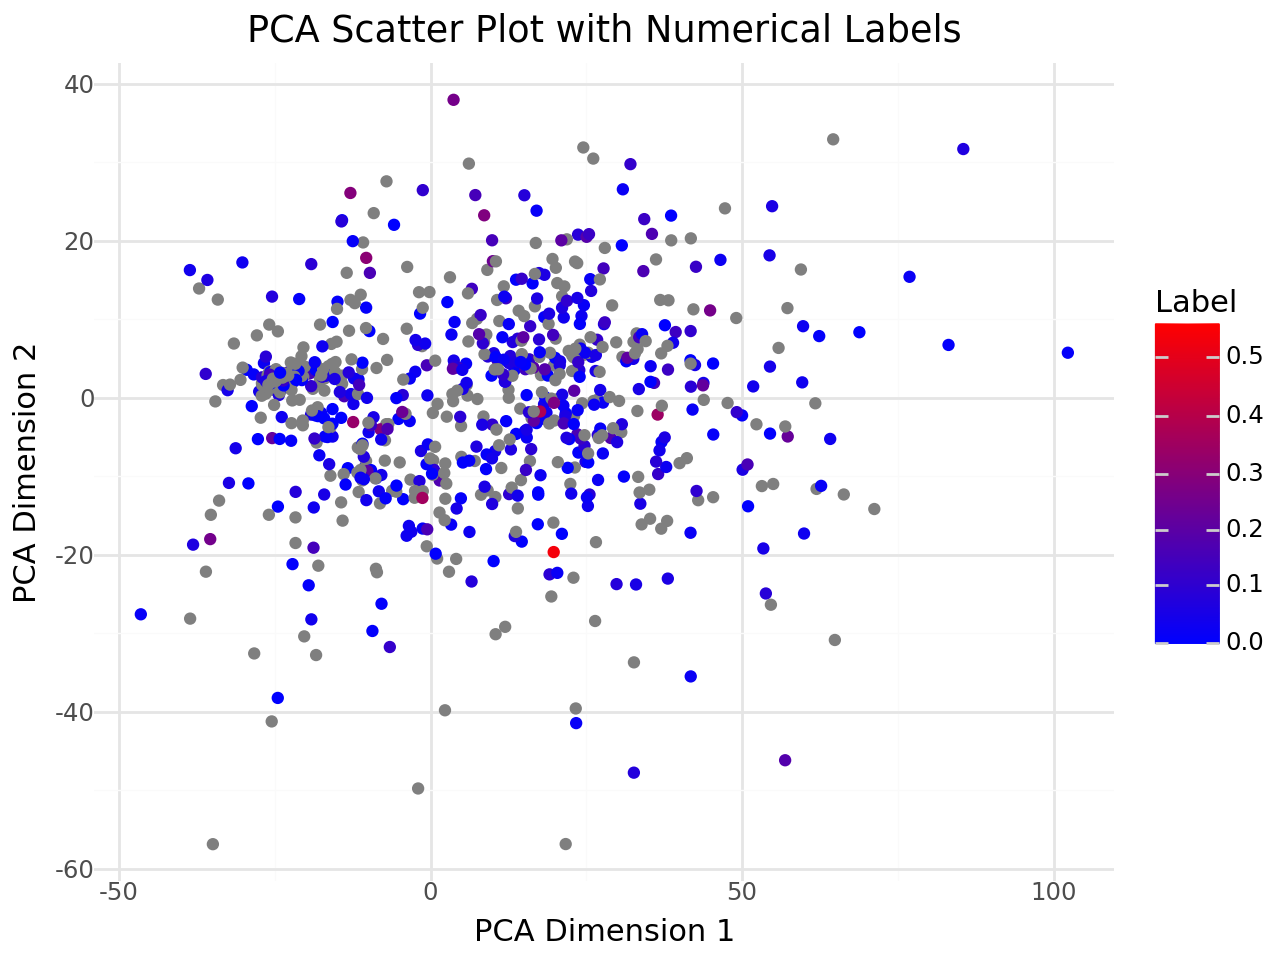

PCA plot for MUT data colored by: Erlotinib


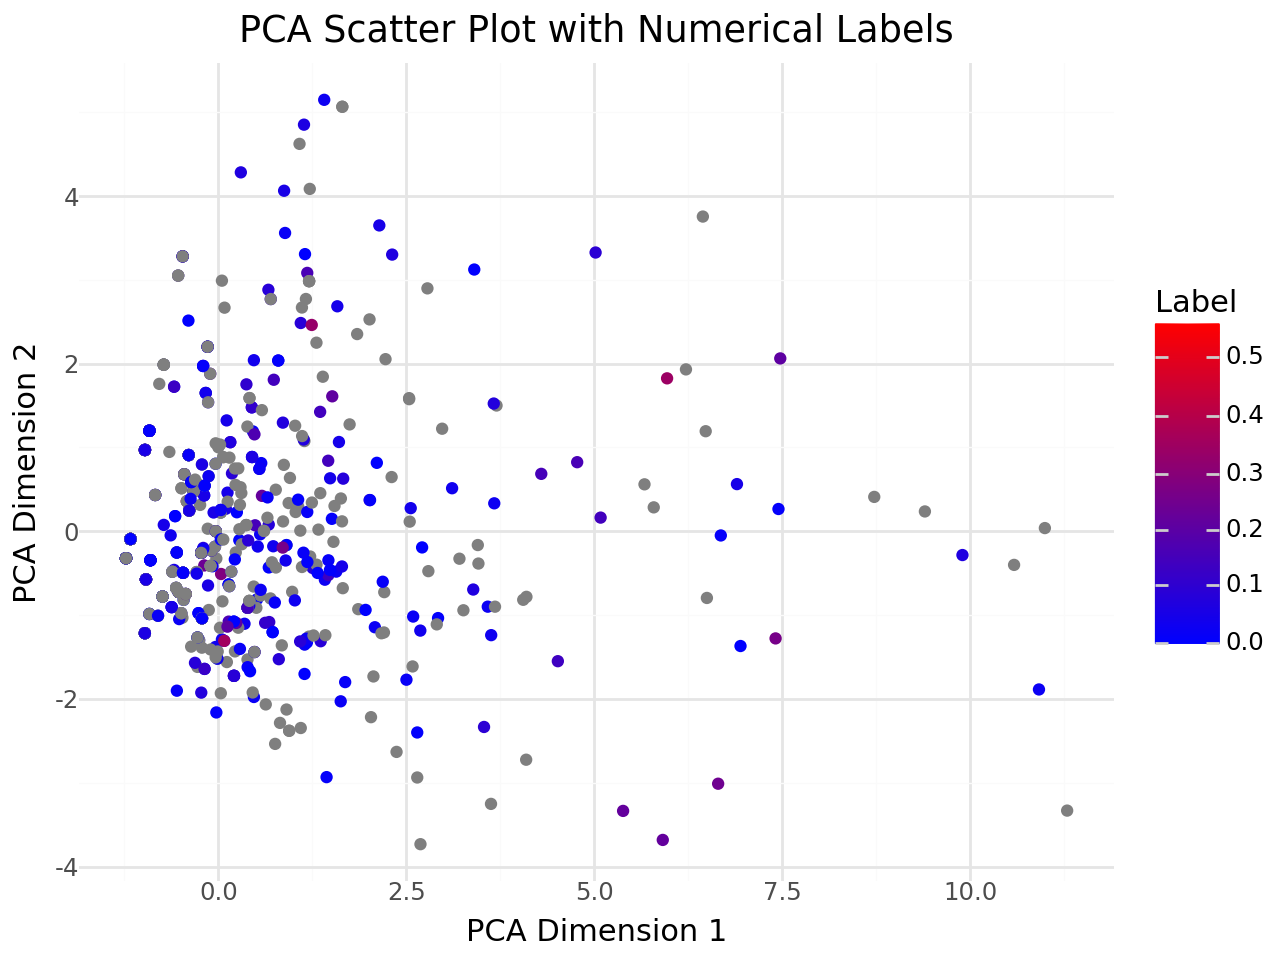

PCA plot for RNA data colored by: Erlotinib


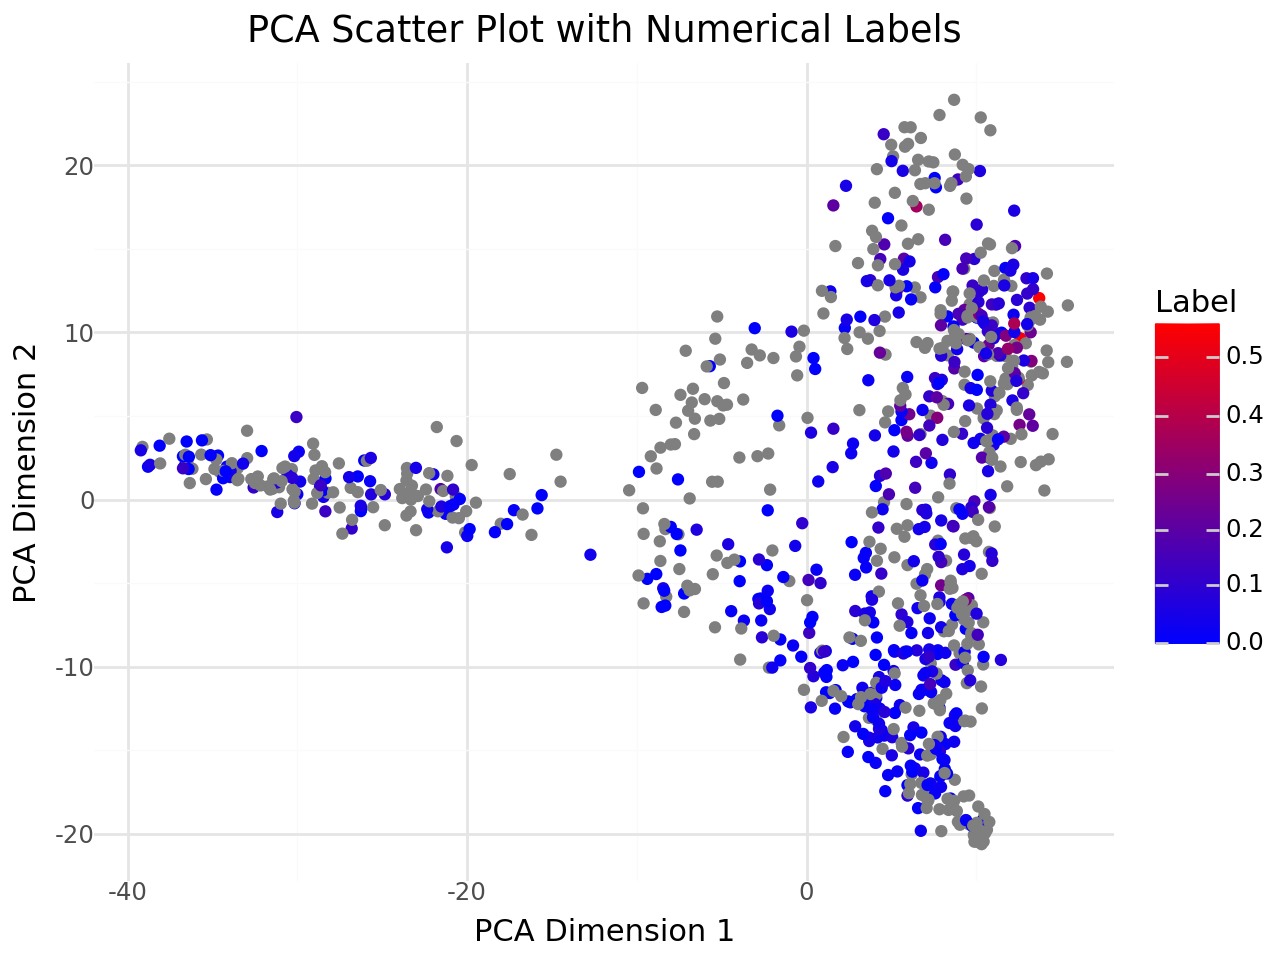

PCA plot for CNV data colored by: Crizotinib


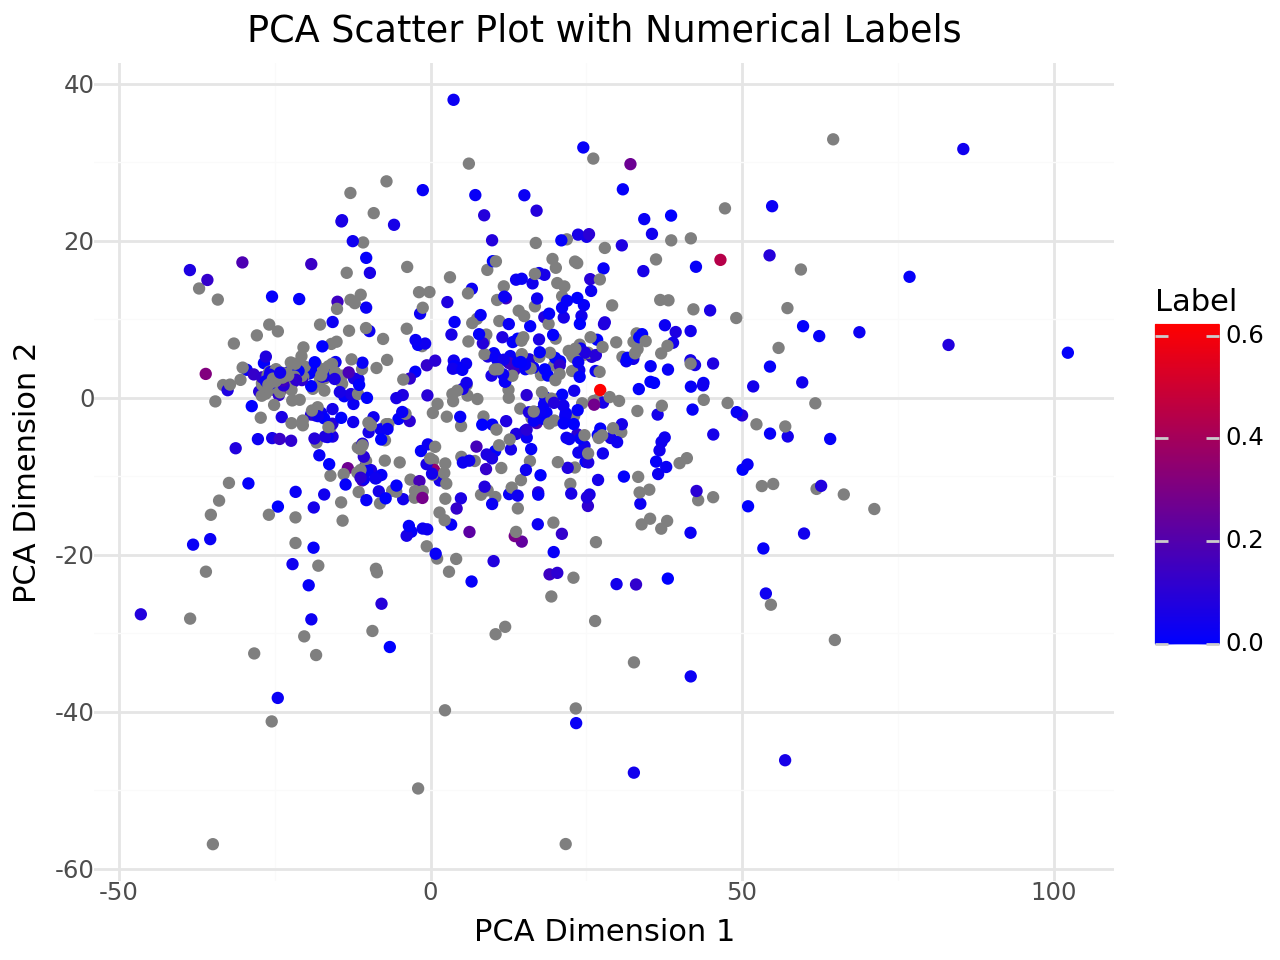

PCA plot for MUT data colored by: Crizotinib


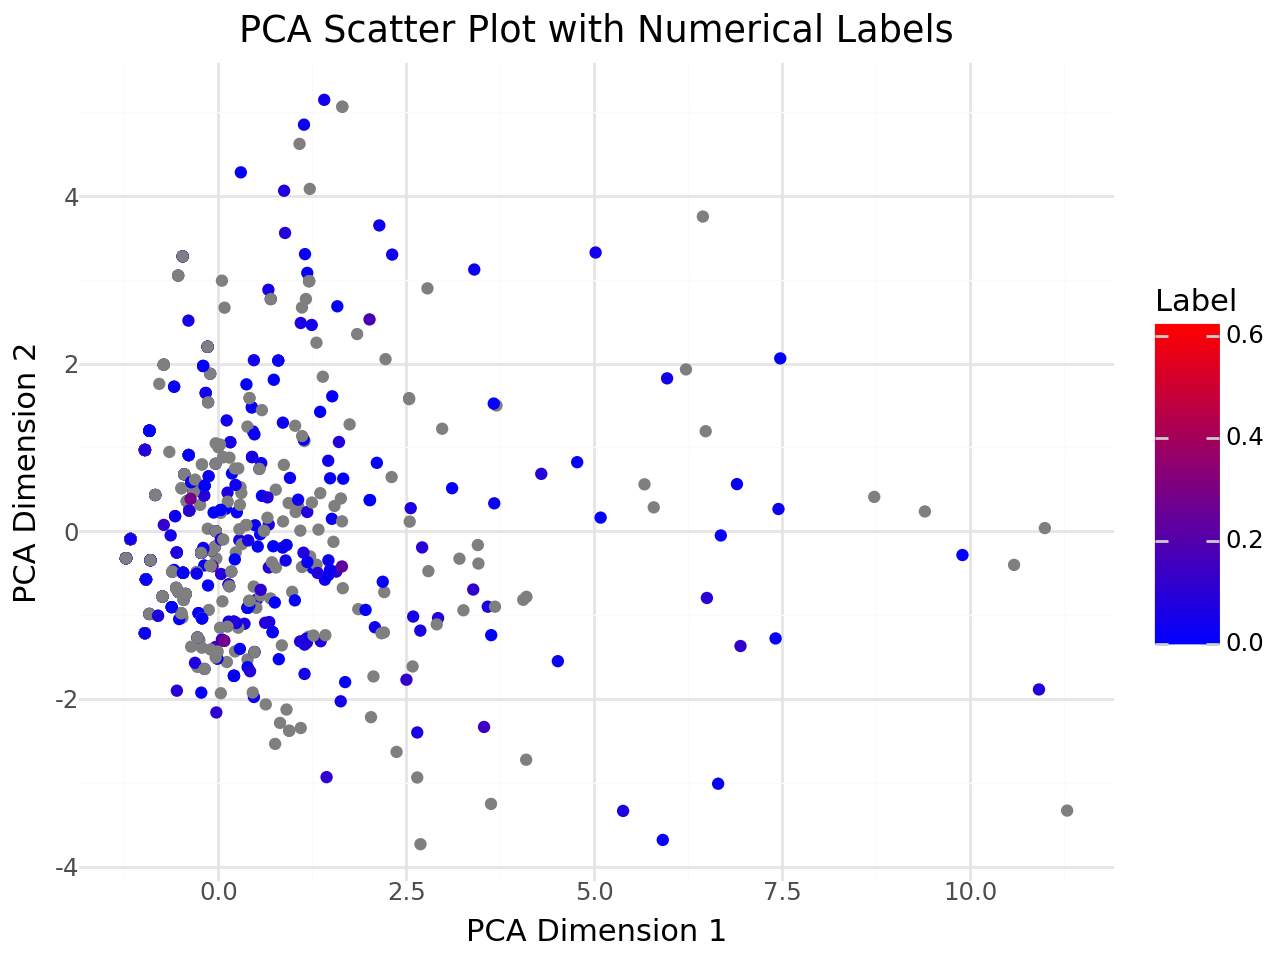

PCA plot for RNA data colored by: Crizotinib


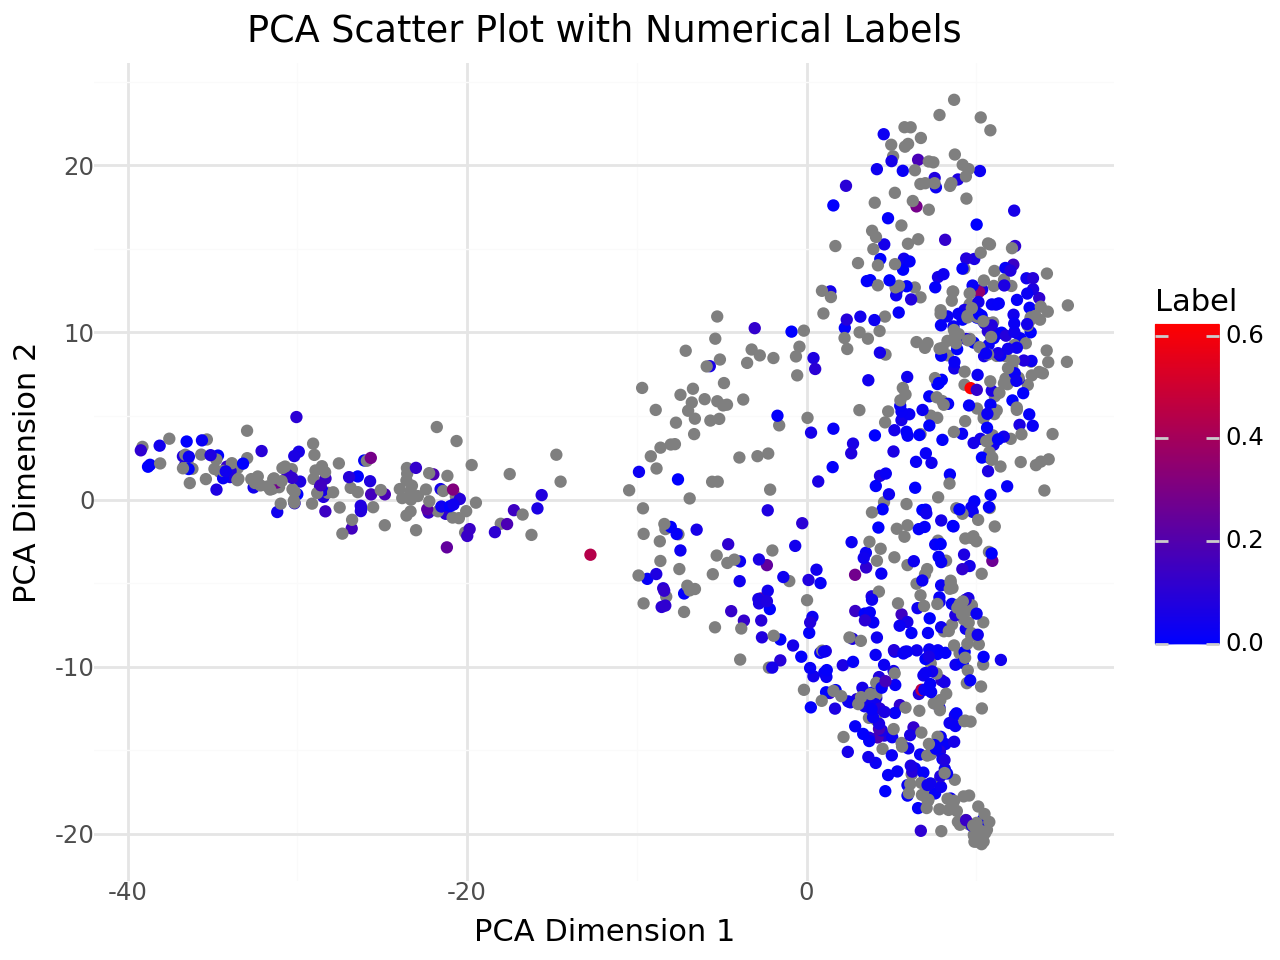

PCA plot for CNV data colored by: Paclitaxel


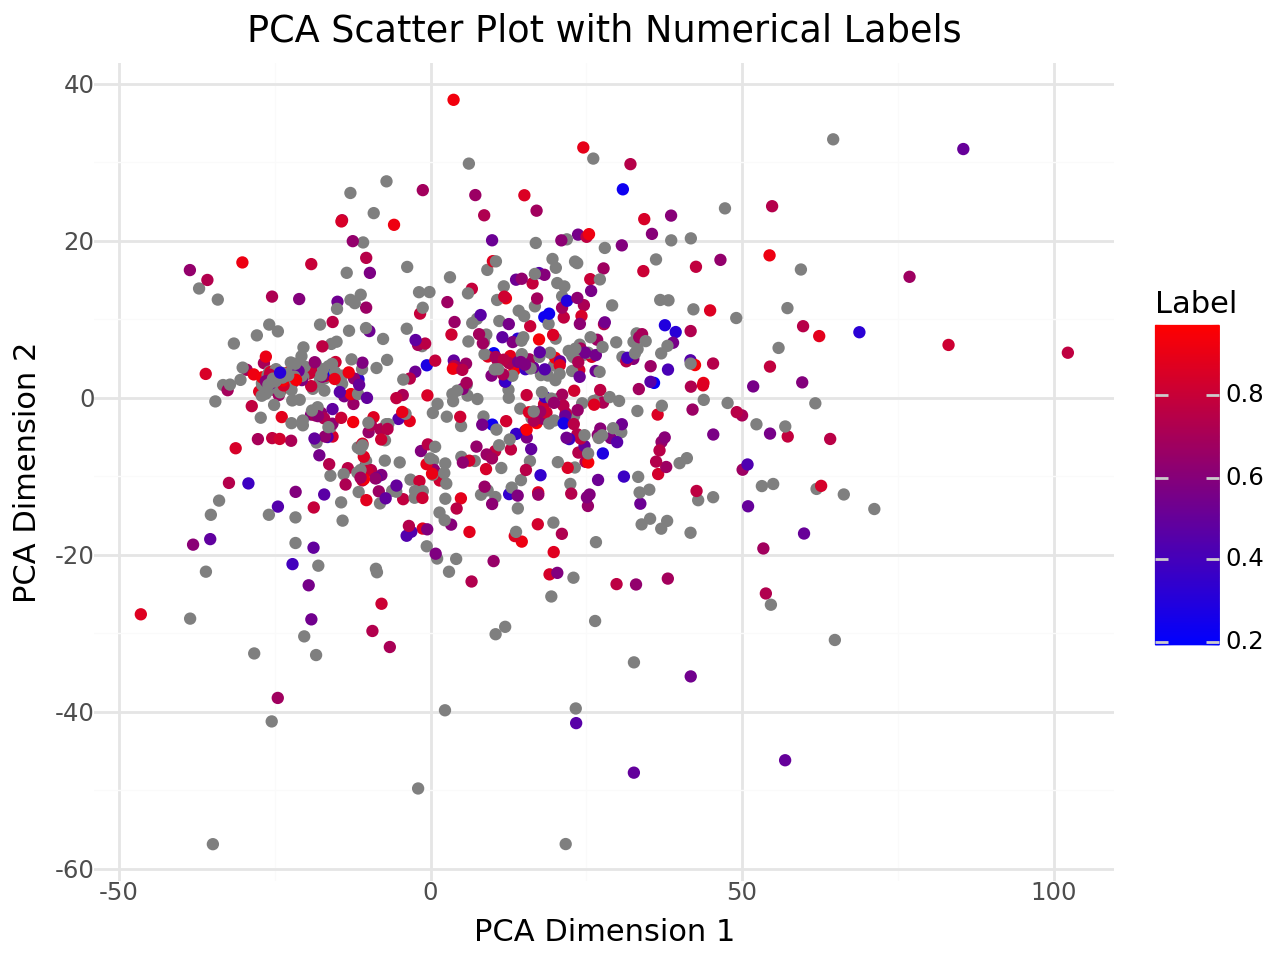

PCA plot for MUT data colored by: Paclitaxel


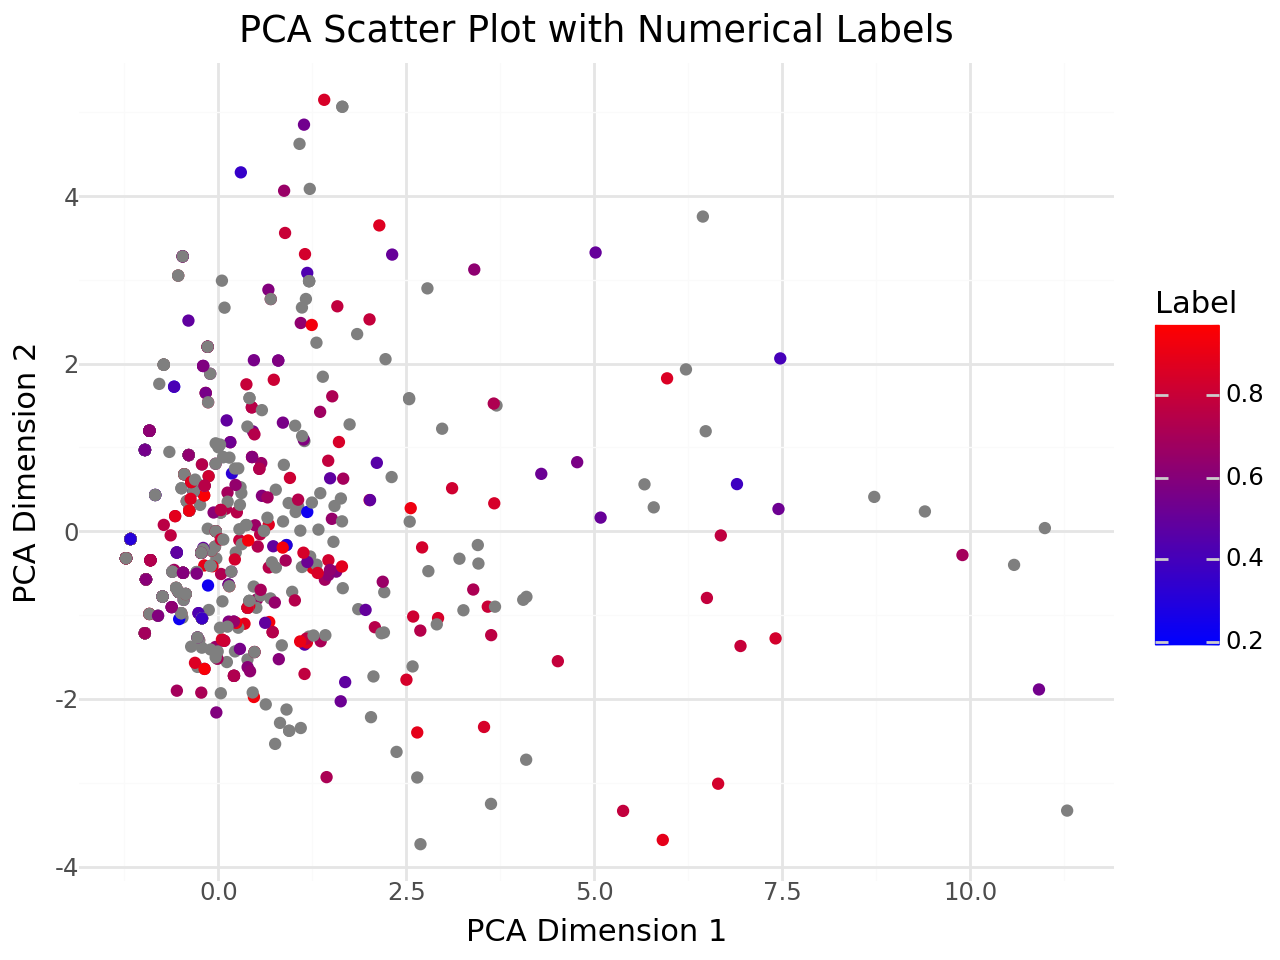

PCA plot for RNA data colored by: Paclitaxel


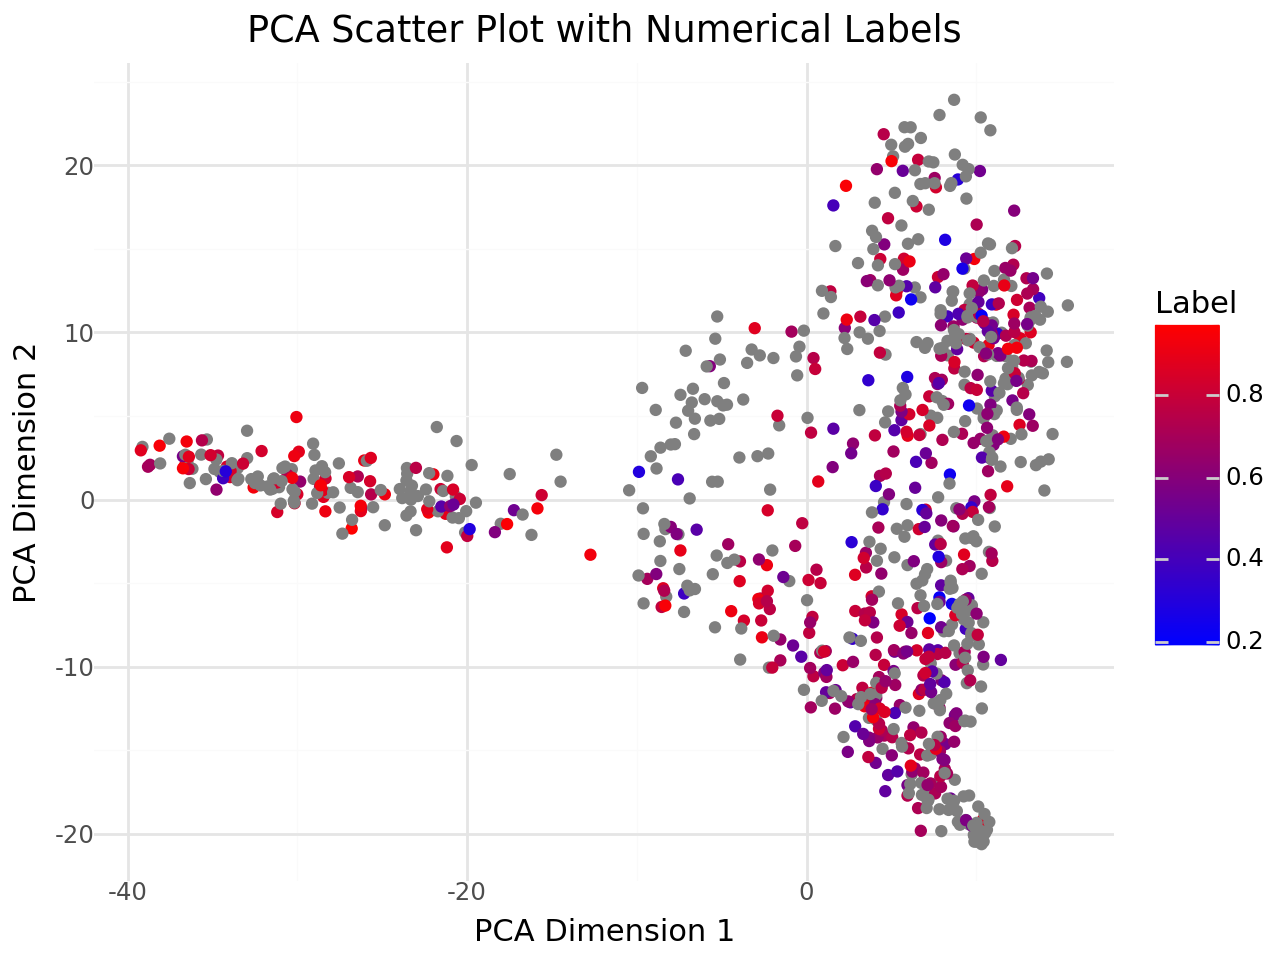

PCA plot for CNV data colored by: Tanespimycin


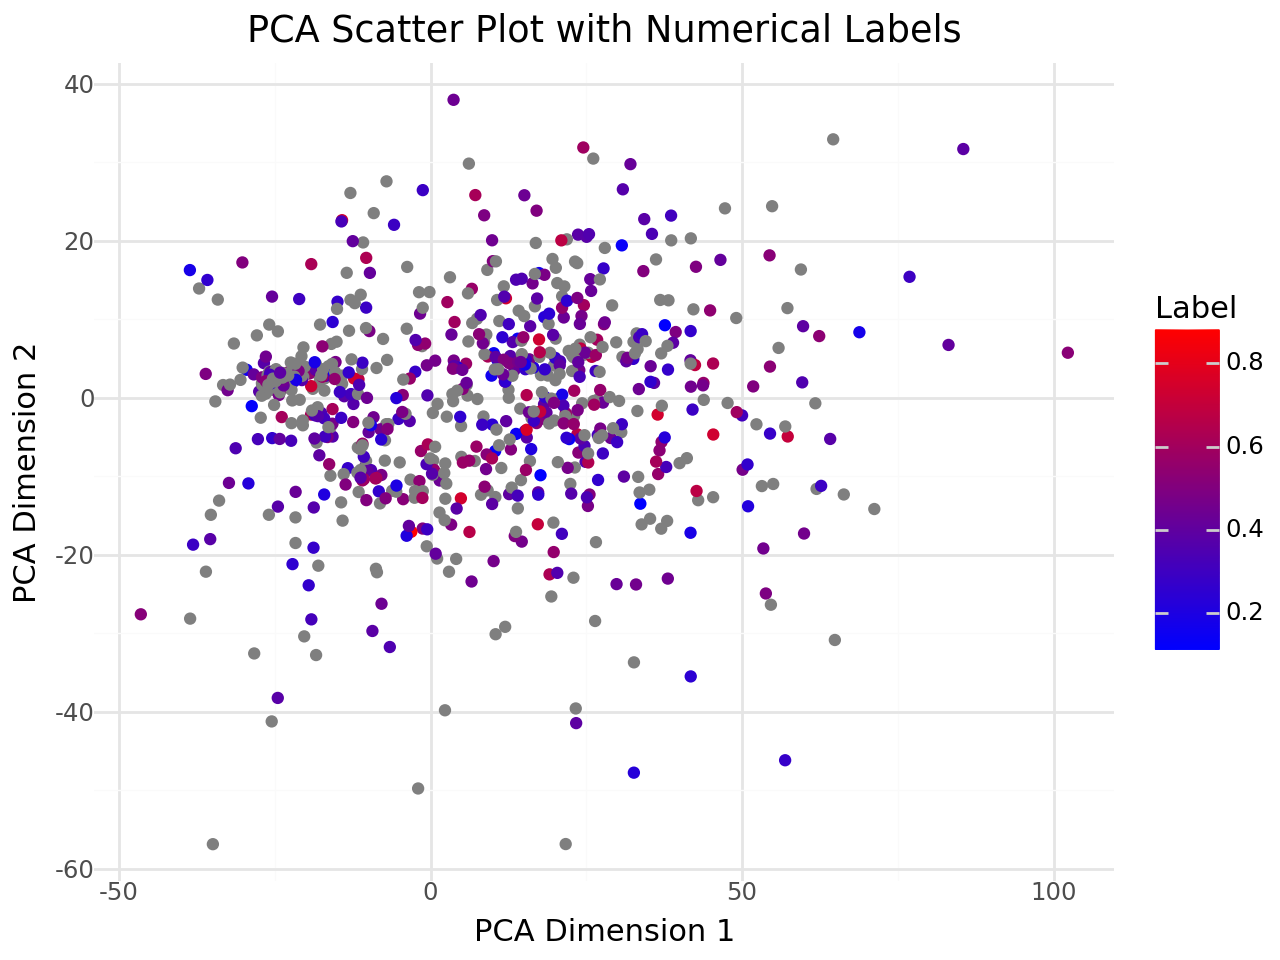

PCA plot for MUT data colored by: Tanespimycin


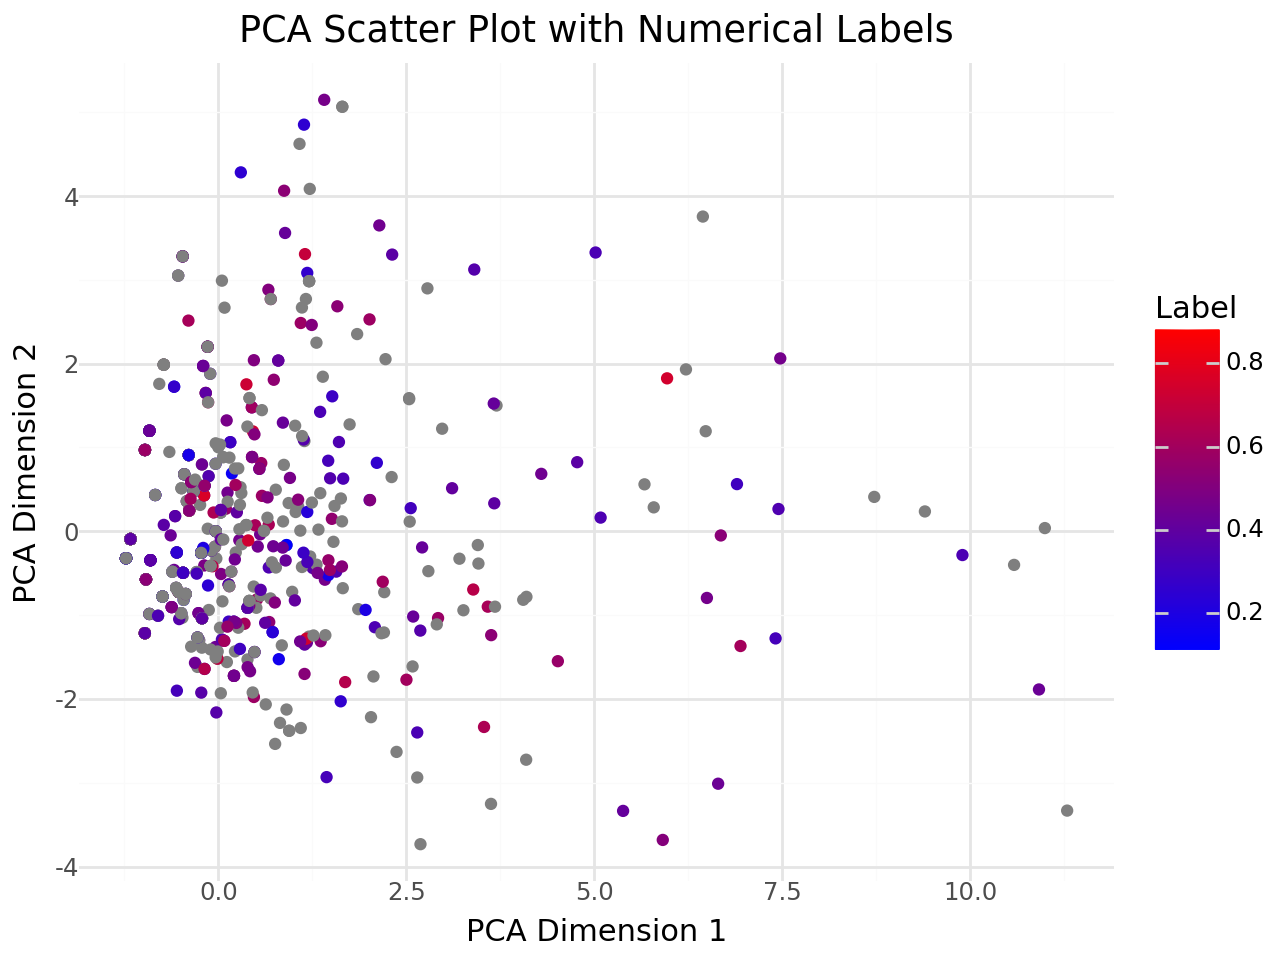

PCA plot for RNA data colored by: Tanespimycin


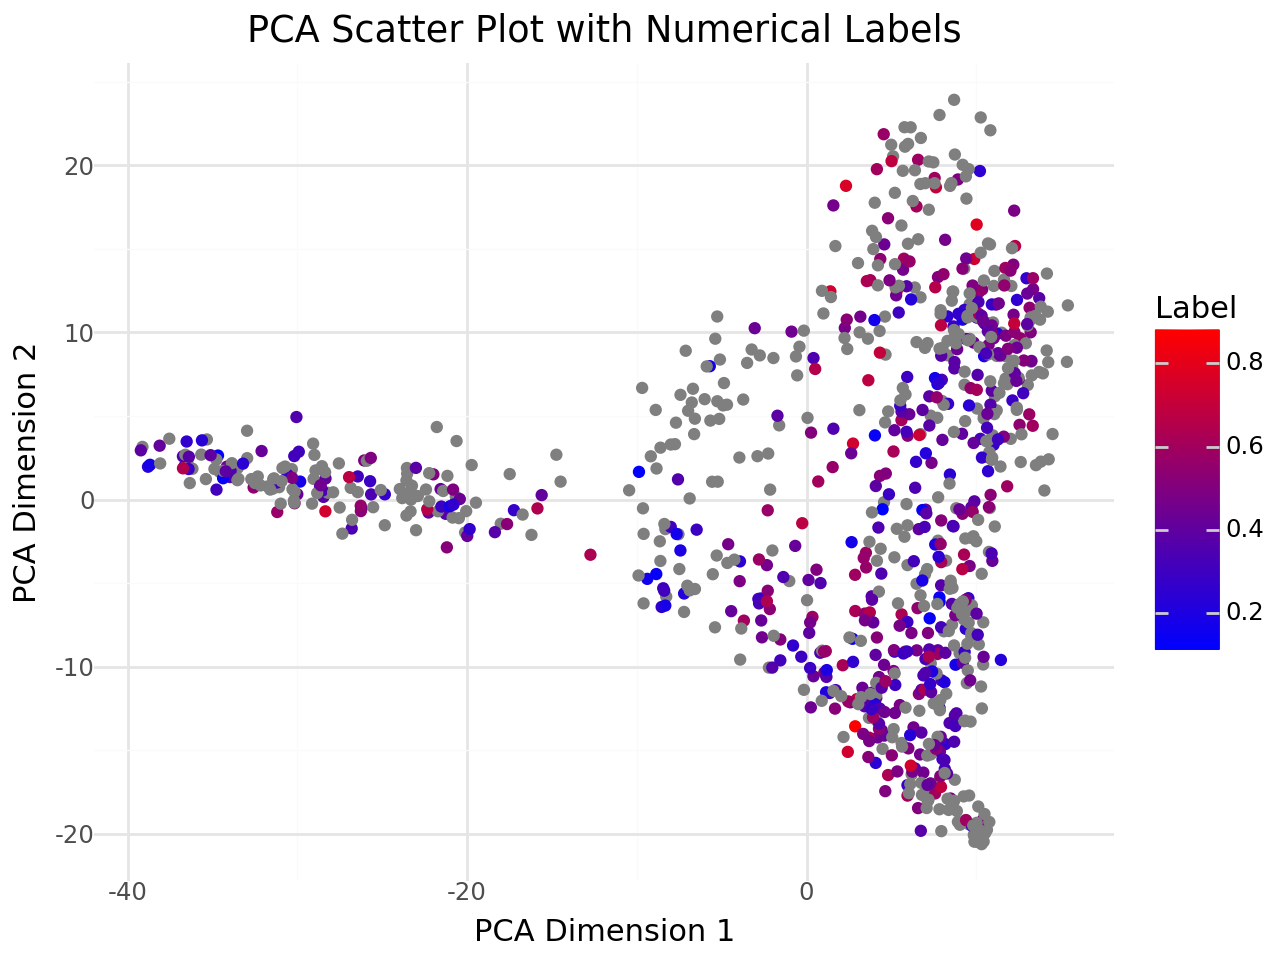

In [22]:
# Loop over each clinical variable and generate PCA plots for both CNA and MUT data
for var in clinical_vars:
    labels, color_type = get_labels(var)
    
    # Plot PCA for CNV data
    print(f"PCA plot for CNV data colored by: {var}")
    fig1 = plot_dim_reduced(df_cnv, labels=labels, color_type=color_type, method="pca")
    # If fig is returned, display it:
    if fig1 is not None:
        fig1.show()
    else:
        plt1.show()
    
    # Plot PCA for MUT data
    print(f"PCA plot for MUT data colored by: {var}")
    fig2 = plot_dim_reduced(df_mut, labels=labels, color_type=color_type, method="pca")
    # If fig is returned, display it:
    if fig2 is not None:
        fig2.show()
    else:
        plt2.show()

    # Plot PCA for RNA data
    print(f"PCA plot for RNA data colored by: {var}")
    fig3 = plot_dim_reduced(df_rna, labels=labels, color_type=color_type, method="pca")
    # If fig is returned, display it:
    if fig3 is not None:
        fig3.show()
    else:
        plt3.show()

### Generate all models
#### Total: 24 (non-GNN) + 12 (GNN) = 36
##### Different data modality combinations
DATA_TYPE_LIST=("mutation" "rna" "cnv" "mutation,cnv" "mutation,rna" "rna,cnv")

##### Two fusion types for non-GNN models
FUSION_MODES=("early" "intermediate")

##### Non-GNN model classes
NON_GNN_CLASSES=("DirectPred" "supervised_vae")

##### GNN model class and convolution types
GNN_CLASS="GNN"
GNN_CONV_TYPES=("GC" "SAGE")

In [ ]:
#!bash multiomics_ccle_vs_gdsc_eval.sh
!bash check_multiomics_ccle_vs_gdsc_eval.sh

Running Flexynesis for Erlotinib (CCLE vs GDSC) with skipping if present
Data path:         /home/thesamurai/sciebo/Project_Allocation/module3_trial_multiomics/compgen_course_2025_module3_my_session/submissions/day3/ccle_vs_gdsc/
Target variable:   Erlotinib
HPO iterations:    15
Threads:           12
Num workers:       6
-----------------------------------------------------------
Model: DirectPred | Data: mutation | Fusion: early
Prefix: run_DirectPred_mutation_early
-----------------------------------------------------------
-----------------------------------------------------------
Model: DirectPred | Data: mutation | Fusion: intermediate
Prefix: run_DirectPred_mutation_intermediate
-----------------------------------------------------------
-----------------------------------------------------------
Model: DirectPred | Data: rna | Fusion: early
Prefix: run_DirectPred_rna_early
-----------------------------------------------------------


#### a) Import the results of the experiments from step 3, and rank the experiments based on performance (pearson_corr) Which combination yields the best results?

In [ ]:
# Directory where logs and results are stored
LOGS_DIR = "logs_flexynesis"

# 1. Gather all .stats.csv files in LOGS_DIR
stats_files = glob.glob(os.path.join(LOGS_DIR, "**", "*.stats.csv"), recursive=True)

results = []
for file_path in stats_files:
    # Derive prefix from the filename (assuming e.g. "run_DirectPred_mut_early.stats.csv")
    prefix = os.path.basename(file_path).replace(".stats.csv", "")

    df_stats = pd.read_csv(file_path)

    # 2. Locate the row with metric == "pearson_corr"
    df_pearson = df_stats[df_stats["metric"] == "pearson_corr"]

    if not df_pearson.empty:
        pearson_val = df_pearson["value"].iloc[0]
    else:
        pearson_val = None  # if it doesn't exist

    results.append({
        "Prefix": prefix,
        "FilePath": file_path,
        "PearsonCorr": pearson_val
    })

# Convert to a DataFrame
results_df = pd.DataFrame(results)

# Drop rows with no pearson_corr available (if any)
results_df.dropna(subset=["PearsonCorr"], inplace=True)

# Sort experiments by pearson_corr descending (best at top)
results_df.sort_values(by="PearsonCorr", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

print("Ranking of experiments by Pearson correlation (descending):")
display(results_df)

# Visualize the Pearson correlation across experiments in a simple bar chart
plt.figure(figsize=(10, 5))
plt.bar(results_df["Prefix"], results_df["PearsonCorr"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Experiment Prefix")
plt.ylabel("Pearson Correlation")
plt.title("Experiment Ranking by Pearson Correlation (Erlotinib Prediction)")
plt.tight_layout()
plt.show()

# Identify the best model (highest PearsonCorr)
best_model_prefix = results_df.iloc[0]["Prefix"]
print(f"The best model prefix is: {best_model_prefix}")

#### b) Explore the train/test embeddings from the best model (from 4a).

In [ ]:
best_model_prefix = best_model_prefix #"run_DirectPred_mut_early"  # Replace with the actual best from part (A)

BEST_MODEL_DIR = os.path.join(LOGS_DIR, best_model_prefix)

# Embedding files look like: "<prefix>.embeddings_train.csv" and "<prefix>.embeddings_test.csv"
train_embeddings_path = os.path.join(BEST_MODEL_DIR, f"{best_model_prefix}.embeddings_train.csv")
test_embeddings_path  = os.path.join(BEST_MODEL_DIR, f"{best_model_prefix}.embeddings_test.csv")

# 1) Read and rename columns so the first column = "sample_id"
df_train_embed = pd.read_csv(train_embeddings_path)
df_test_embed = pd.read_csv(test_embeddings_path)

# Rename the first column in each to "sample_id" (since it's originally the sample name)
df_train_embed.rename(columns={df_train_embed.columns[0]: "sample_id"}, inplace=True)
df_test_embed.rename(columns={df_test_embed.columns[0]: "sample_id"}, inplace=True)

print("Train Embeddings Shape:", df_train_embed.shape)
print("Test Embeddings Shape:", df_test_embed.shape)

# 2) Identify the embedding columns ("E0", "E1", ..., "E17"). 
#    We assume all columns except the first one are the embedding features.
embedding_cols = df_train_embed.columns[1:]  # E0..E17 for train

# 3) Run PCA on the numeric embedding columns only
pca = PCA(n_components=2)

# Fit on train, transform train and test
train_pca = pca.fit_transform(df_train_embed[embedding_cols])
test_pca  = pca.transform(df_test_embed[embedding_cols])

# 4) Plot the train/test embeddings in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(train_pca[:,0], train_pca[:,1], alpha=0.6, label="Train")
plt.scatter(test_pca[:,0], test_pca[:,1], alpha=0.6, label="Test")
plt.title(f"PCA of Train/Test Embeddings for {best_model_prefix}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Display a small sample of each embedding DataFrame
print("Sample Train Embeddings:")
display(df_train_embed.head())

print("Sample Test Embeddings:")
display(df_test_embed.head())

#### c) Import the feature importance scores from the best model (from 4a). Get top 10 markers.

In [ ]:
#BEST_MODEL_DIR = os.path.join(LOGS_DIR, best_model_prefix)
feature_importance_path = os.path.join(BEST_MODEL_DIR, f"{best_model_prefix}.feature_importance.IntegratedGradients.csv")

# 1. Read the feature importance CSV
df_importance = pd.read_csv(feature_importance_path)

# Columns: target_variable, target_class, target_class_label, layer, name, importance, explainer
# 2. Sort by highest 'importance'
df_importance.sort_values(by="importance", ascending=False, inplace=True)

# 3. Extract the top 10 markers
top10 = df_importance.head(10)

print(f"Top 10 markers from {best_model_prefix}:")
display(top10)

# 4. Provide placeholders for further analysis
print("Next step: check if these markers (in 'name' column) are known to be related to Erlotinib response.")

#### Do literature search. Are any of the top markers associated to “Erlotinib”?

The following references provide insights into the relationship between Erlotinib treatment and various cancer cell lines, particularly focusing on their mechanisms of action, resistance, and therapeutic implications.

1. Lee et al.: The study performed a comparative metabolomic analysis of HPAC cells and revealed that glutamate levels were significantly higher in erlotinib-resistant non-small cell lung cancer cells (PC-9ER) relative to their erlotinib-sensitive counterparts (PC-9), illustrating metabolic pathways associated with drug resistance Lee et al. (2017).

2. Cavazzoni et al.: This research investigated the combined use of anti-ErbB monoclonal antibodies and erlotinib to enhance antibody-dependent cellular cytotoxicity in NSCLC cell lines. The study underscored the role of erlotinib in modulating protein levels related to survival and resistance in cancer cells (Cavazzoni et al., 2012).

3. Zhang et al.: The article focused on AXL kinase's activation and its role in mediating resistance to EGFR-targeted therapy, including erlotinib, emphasizing the signaling pathways involved in acquired resistance in lung cancer cell lines (Zhang et al., 2012).

4. Zhang et al.: This study demonstrated that silencing the kinase-interacting stathmin gene can enhance erlotinib sensitivity in breast cancer models, suggesting a potential therapeutic approach to overcome EGFR inhibitor resistance (Zhang et al., 2010).

5. Yi et al.: This research highlighted how inhibiting the PI3K/AKT pathway can increase the cytotoxicity of EGFR kinase inhibitors, reinforcing the potential synergistic effects of combining these pathways in treating triple-negative breast cancer (Yi et al., 2013).

6. Gusenbauer et al.: This article elaborated on how hepatocyte growth factor (HGF) influences the formation of resistance against tyrosine kinase inhibitors like erlotinib by modulating EGFR interactions and downstream signaling in lung cancer cells (Gusenbauer et al., 2012).

7. Yang et al.: A phase III clinical trial compared the efficacy of erlotinib to gefitinib in patients with advanced NSCLC harboring EGFR mutations, providing essential insights into the frontline treatment strategies for this patient population (Yang et al., 2017).

8. Fernando et al.: The study revealed that IL-8 signaling plays a significant role in the resistance of lung carcinoma cells to erlotinib, contributing to a better understanding of tumor microenvironment interactions and therapeutic resistance mechanisms (Fernando et al., 2016).

9. Herbst et al.: This trial assessed the combination of bevacizumab and erlotinib in patients with NSCLC who had previously undergone chemotherapy, focusing on the feasibility and effectiveness of this treatment approach (Herbst et al., 2011).

10. Fan et al.: The research explored the role of MET-independent lung cancer cells in evading EGFR kinase inhibitors, suggesting potential therapeutic strategies involving concurrent inhibition of multiple pathways (Fan et al., 2011).

11. Fidias and Novello: The authors reviewed strategies for prolonging therapy in advanced non-small-cell lung cancer, relevant to the ongoing discussion of erlotinib effectiveness in various histological contexts (Fidias & Novello, 2010).

12. Bartholomeusz et al.: This study highlighted how gemcitabine could overcome erlotinib resistance in EGFR-overexpressing cancer cells through the downregulation of Akt, suggesting a potential combinatorial treatment strategy (Bartholomeusz et al., 2011).

13. Karnthaler-Benbakka et al.: This article examined the effects of a hypoxia-activatable prodrug approach combined with erlotinib in sensitive cell lines, collecting data that supports its therapeutic viability (Karnthaler‐Benbakka et al., 2016).

14. Jang et al.: The study's findings propose that ornithine decarboxylase contributes to erlotinib resistance mechanisms in pancreatic cancer, presenting a novel avenue for therapeutic intervention (Jang et al., 2017).

15. He et al.: This preprint discusses the sensitization of pancreatic cancer to erlotinib through the silencing of the DJ-1 gene, underscoring potential pharmacological targets in overcoming drug resistance (He et al., 2019).

16. Shintani et al.: This research identifies the role of eukaryotic translation initiation factor 3 subunit C in acquired resistance to erlotinib, indicating a key player in the resistance mechanisms of certain lung cancer cell lines (Shintani et al., 2018).

17. Wong et al.: This article discusses the co-inhibition of the MAPK and PI3K/Akt/mTOR pathways in pancreatic ductal adenocarcinoma, providing insight into combinatorial strategies to enhance anticancer efficacy alongside erlotinib (Wong et al., 2016).

18. Siegman et al.: The research explores the relationship between KRAS mutation status and the effects of erlotinib treatment on autophagy-related mechanisms, contributing to the understanding of context-dependent responses to therapy (Siegman et al., 2024).

19. Lee and Wu: This study indicates that the combination of erlotinib with cisplatin can be effective against resistant lung cancer cells, providing rationale for further clinical exploration of combination therapies (Lee & Wu, 2012).

20. Lypova et al.: The article demonstrates that PFKFB3 inhibition impairs autophagy induced by erlotinib in NSCLCs, suggesting important interactions between metabolic pathways and drug responses (Lypova et al., 2021).

21. Ding et al.: This case report raises concerns over acute myocardial infarction linked to erlotinib treatment in NSCLC, presenting essential safety considerations in clinical practice (Ding et al., 2016).

22. Zheng et al.: The study revealed that amiloride can sensitize pancreatic cancer cells to erlotinib by inhibiting the PI3K/AKT signaling pathway, indicating a strategy for enhancing therapeutic efficacy (Zheng et al., 2015).

23. Al-Hamaly et al.: The study in zebrafish outlines the role of erlotinib in inhibiting Wnt/β-Catenin signaling in T-ALL, contributing to understanding its effects in hematological malignancies (Al-Hamaly et al., 2023).

24. Otahal et al.: This research explored how statins can synergistically enhance the effects of erlotinib in NSCLC cells, pointing toward combination therapies that may overcome drug resistance (Otahal et al., 2020).

25. Furugaki: The study examined schedule-dependent antitumor activities when combining erlotinib with docetaxel in NSCLC, supporting the efficacy of targeted combinations tailored to specific mutation profiles (Furugaki, 2010).

These references collectively highlight the multifaceted roles of Erlotinib in treating cancer, addressing mechanisms of resistance, potential combination therapies, and implications for specific cancer types.

References:
Furugaki, F. (2010). Schedule-dependent antitumor activity of the combination with erlotinib and docetaxel in human non-small cell lung cancer cells with egfr mutation, kras mutation or both wild-type egfr and kras. Oncology Reports, 24(5). https://doi.org/10.3892/or_00000965
Al-Hamaly, M., Cox, A., Haney, M., Zhang, W., Arvin, E., Sampathi, S., … & Blackburn, J. (2023). Zebrafish drug screening identifies erlotinib as an inhibitor of wnt/β-catenin signaling and self-renewal in t-cell acute lymphoblastic leukemia.. https://doi.org/10.1101/2023.08.28.555200
Attri, S., Lone, M., Katiyar, A., Sharma, V., Kumar, V., Verma, C., … & Gahlawat, S. (2023). Genetic analysis of hibm myopathy-specific gne v727m hotspot mutation identifies a novel col6a3 allied gene signature that is also deregulated in multiple neuromuscular diseases and myopathies. Genes, 14(3), 567. https://doi.org/10.3390/genes14030567
Bartholomeusz, C., Yamasaki, F., Saso, H., Kurisu, K., Hortobágyi, G., & Ueno, N. (2011). Gemcitabine overcomes erlotinib resistance in egfr-overexpressing cancer cells through downregulation of akt. Journal of Cancer, 2, 435-442. https://doi.org/10.7150/jca.2.435
Beyer, S., Bell, E., McElroy, J., Fleming, J., Cui, T., Becker, A., … & Chakravarti, A. (2018). Oncogenictransgelin-2is differentially regulated inisocitrate dehydrogenasewild-type vs. mutant gliomas. Oncotarget, 9(98), 37097-37111. https://doi.org/10.18632/oncotarget.26365
Bralten, L., Kloosterhof, N., Balvers, R., Sacchetti, A., Lapre, L., Lamfers, M., … & French, P. (2011). Idh1 r132h decreases proliferation of glioma cell lines in vitro and in vivo. Annals of Neurology, 69(3), 455-463. https://doi.org/10.1002/ana.22390
Brat, D., Verhaak, R., Aldape, K., Yung, W., Salama, S., Cooper, L., … & Zhang, J. (2015). Comprehensive, integrative genomic analysis of diffuse lower-grade gliomas. New England Journal of Medicine, 372(26), 2481-2498. https://doi.org/10.1056/nejmoa1402121
Cai, H., Yu, Y., Ni, X., Li, C., Hu, Y., Wang, J., … & Chen, Z. (2020). Lncrna linc00998 inhibits the malignant glioma phenotype via the cbx3-mediated c-met/akt/mtor axis. Cell Death and Disease, 11(12). https://doi.org/10.1038/s41419-020-03247-6
Cai, J., Zhu, P., Zhang, C., Li, Q., Wang, Z., Li, G., … & Jiang, T. (2016). Detection of atrx and idh1-r132h immunohistochemistry in the progression of 211 paired gliomas. Oncotarget, 7(13), 16384-16395. https://doi.org/10.18632/oncotarget.7650
Cavazzoni, A., Alfieri, R., Cretella, D., Saccani, F., Ampollini, L., Galetti, M., … & Ardizzoni, A. (2012). Combined use of anti-erbb monoclonal antibodies and erlotinib enhances antibody-dependent cellular cytotoxicity of wild-type erlotinib-sensitive nsclc cell lines. Molecular Cancer, 11(1). https://doi.org/10.1186/1476-4598-11-91
Chen, G., Kuai, D., Cai, S., Xue, N., Liu, Y., Hao, J., … & Guo, Y. (2013). Knockdown of frat1 expression by rna interference inhibits human glioblastoma cell growth, migration and invasion. Plos One, 8(4), e61206. https://doi.org/10.1371/journal.pone.0061206
Cheng, C., Niu, C., Yang, Y., Wang, Y., & Lu, M. (2013). Expression of hausp in gliomas correlates with disease progression and survival of patients. Oncology Reports, 29(5), 1730-1736. https://doi.org/10.3892/or.2013.2342
Choi, B., Cheong, J., Ryu, J., Won, Y., Min, K., & Han, M. (2024). Significant genes associated with mortality and disease progression in grade ii and iii glioma. Biomedicines, 12(4), 858. https://doi.org/10.3390/biomedicines12040858
Choi, B., Cheong, J., Ryu, J., Won, Y., Min, K., & Han, M. (2024). Significant genes associated with mortality and disease progression in grade ii and iii glioma. Biomedicines, 12(4), 858. https://doi.org/10.3390/biomedicines12040858
Ding, S., Long, F., & Jiang, S. (2016). Acute myocardial infarction following erlotinib treatment for nsclc: a case report. Oncology Letters, 11(6), 4240-4244. https://doi.org/10.3892/ol.2016.4508
Fan, W., Tang, Z., Yin, L., Morrison, B., Hafez-Khayyata, S., Fu, P., … & Patrick, C. (2011). Met-independent lung cancer cells evading egfr kinase inhibitors are therapeutically susceptible to bh3 mimetic agents. Cancer Research, 71(13), 4494-4505. https://doi.org/10.1158/0008-5472.can-10-2668
Fernando, R., Hamilton, D., Dominguez, C., David, J., McCampbell, K., & Palena, C. (2016). Il-8 signaling is involved in resistance of lung carcinoma cells to erlotinib. Oncotarget, 7(27), 42031-42044. https://doi.org/10.18632/oncotarget.9662
Fidias, P. and Novello, S. (2010). Strategies for prolonged therapy in patients with advanced non–small-cell lung cancer. Journal of Clinical Oncology, 28(34), 5116-5123. https://doi.org/10.1200/jco.2010.30.7074
Gusenbauer, S., Vlaicu, P., & Ullrich, A. (2012). Hgf induces novel egfr functions involved in resistance formation to tyrosine kinase inhibitors. Oncogene, 32(33), 3846-3856. https://doi.org/10.1038/onc.2012.396
Hartmann, C., Hentschel, B., Tatagiba, M., Schramm, J., Schnell, O., Seidel, C., … & Weller, M. (2011). Molecular markers in low-grade gliomas: predictive or prognostic?. Clinical Cancer Research, 17(13), 4588-4599. https://doi.org/10.1158/1078-0432.ccr-10-3194
He, X., Sun, Y., Fan, R., Sun, J., Zou, D., & Yuan, Y. (2019). Silencing of the dj-1 (park7) gene sensitizes pancreatic cancer to erlotinib inhibition.. https://doi.org/10.21203/rs.2.12426/v1
Herbst, R., Ansari, R., Bustin, F., Flynn, P., Hart, L., Otterson, G., … & Hainsworth, J. (2011). Efficacy of bevacizumab plus erlotinib versus erlotinib alone in advanced non-small-cell lung cancer after failure of standard first-line chemotherapy (beta): a double-blind, placebo-controlled, phase 3 trial. The Lancet, 377(9780), 1846-1854. https://doi.org/10.1016/s0140-6736(11)60545-x
Jang, W., Choi, B., Song, S., Lee, N., Kim, D., Lee, S., … & Jeong, C. (2017). Multi-omics analysis reveals that ornithine decarboxylase contributes to erlotinib resistance in pancreatic cancer cells. Oncotarget, 8(54), 92727-92742. https://doi.org/10.18632/oncotarget.21572
Ji, X., Zhang, H., & Cui, Q. (2019). A panel of synapse assembly genes as a biomarker for gliomas.. https://doi.org/10.1101/19011114
Kang, K., Xie, F., Wu, Y., Chang, H., Bai, Y., Long, J., … & Zhang, F. (2021). Genomic instability in lower-grade glioma: prediction of prognosis based on lncrna and immune infiltration. Molecular Therapy — Oncolytics, 22, 431-443. https://doi.org/10.1016/j.omto.2021.07.011
Karnthaler‐Benbakka, C., Groza, D., Koblmüller, B., Terenzi, A., Holste, K., Haider, M., … & Keppler, B. (2016). Targeting a targeted drug: an approach toward hypoxia‐activatable tyrosine kinase inhibitor prodrugs. Chemmedchem, 11(21), 2410-2421. https://doi.org/10.1002/cmdc.201600417
Khozin, S., Blumenthal, G., Jiang, X., He, K., Boyd, K., Murgo, A., … & Pazdur, R. (2014). U.s. food and drug administration approval summary: erlotinib for the first-line treatment of metastatic non-small cell lung cancer with epidermal growth factor receptor exon 19 deletions or exon 21 (l858r) substitution mutations. The Oncologist, 19(7), 774-779. https://doi.org/10.1634/theoncologist.2014-0089
Kim, Y., Pierscianek, D., Mittelbronn, M., Vital, A., Mariani, L., Hasselblatt, M., … & Ohgaki, H. (2011). tet2promoter methylation in low-grade diffuse gliomas lackingidh1/2mutations: figure 1. Journal of Clinical Pathology, 64(10), 850-852. https://doi.org/10.1136/jclinpath-2011-200133
Koso, H., Takeda, H., Yew, C., Ward, J., Nariai, N., Ueno, K., … & Jenkins, N. (2012). Transposon mutagenesis identifies genes that transform neural stem cells into glioma-initiating cells. Proceedings of the National Academy of Sciences, 109(44). https://doi.org/10.1073/pnas.1215899109
Lee, J. and Wu, R. (2012). Combination erlotinib-cisplatin and atg3-mediated autophagy in erlotinib resistant lung cancer. Plos One, 7(10), e48532. https://doi.org/10.1371/journal.pone.0048532
Lee, S., Jang, W., Choi, B., Joo, S., & Jeong, C. (2017). Comparative metabolomic analysis of hpac cells following the acquisition of erlotinib resistance. Oncology Letters, 13(5), 3437-3444. https://doi.org/10.3892/ol.2017.5940
Li, G. and Lan, Q. (2021). Bioinformatics analysis reveals a stem cell-expressed circ-serpine2-mediated mirna-mrna regulatory subnetwork in the malignant progression of glioma. Journal of Translational Medicine, 19(1). https://doi.org/10.1186/s12967-021-03118-4
Li, Y., Hu, X., Li, Q., Wang, F., Zhang, B., Ding, K., … & Zhang, C. (2018). Shikonin sensitizes wild‑type egfr nsclc cells to erlotinib and gefitinib therapy. Molecular Medicine Reports. https://doi.org/10.3892/mmr.2018.9347
Li, Y., Xu, J., Chen, H., Bai, J., Li, S., Zhao, Z., … & Li, X. (2013). Comprehensive analysis of the functional microrna–mrna regulatory network identifies mirna signatures associated with glioma malignant progression. Nucleic Acids Research, 41(22), e203-e203. https://doi.org/10.1093/nar/gkt1054
Luo, F., Liao, Y., Cao, E., Yang, Y., Tang, K., Zhou, D., … & Cai, H. (2023). Hypermethylation of hic2 is a potential prognostic biomarker and tumor suppressor of glioma based on bioinformatics analysis and experiments. CNS Neuroscience & Therapeutics, 29(4), 1154-1167. https://doi.org/10.1111/cns.14093
Lypova, N., Dougherty, S., Lanceta, L., Chesney, J., & Imbert-Fernandez, Y. (2021). Pfkfb3 inhibition impairs erlotinib-induced autophagy in nsclcs. Cells, 10(7), 1679. https://doi.org/10.3390/cells10071679
Otahal, A., Aydemir, D., Tomasich, E., & Minichsdorfer, C. (2020). Delineation of cell death mechanisms induced by synergistic effects of statins and erlotinib in non-small cell lung cancer cell (nsclc) lines. Scientific Reports, 10(1). https://doi.org/10.1038/s41598-020-57707-2
Pirozzi, C., Carpenter, A., Waitkus, M., Wang, C., Zhu, H., Hansen, L., … & Yan, H. (2017). Mutant idh1 disrupts the mouse subventricular zone and alters brain tumor progression. Molecular Cancer Research, 15(5), 507-520. https://doi.org/10.1158/1541-7786.mcr-16-0485
Shintani, T., Higashisaka, K., Maeda, M., Hamada, M., Tsuji, R., Kurihara, K., … & Fujio, Y. (2018). Eukaryotic translation initiation factor 3 subunit c is associated with acquired resistance to erlotinib in non-small cell lung cancer. Oncotarget, 9(101), 37520-37533. https://doi.org/10.18632/oncotarget.26494
Siegman, A., Shaykevich, A., Chae, D., Silverman, I., Goel, S., & Maitra, R. (2024). Erlotinib treatment in colorectal cancer suppresses autophagy based on kras mutation. Current Issues in Molecular Biology, 46(7), 7530-7547. https://doi.org/10.3390/cimb46070447
Wang, J., Qi, J., & Hou, X. (2020). Systematically dissecting the function of rna-binding proteins during glioma progression. Frontiers in Genetics, 10. https://doi.org/10.3389/fgene.2019.01394
Watanabe, T., Nobusawa, S., Kleihues, P., & Ohgaki, H. (2009). Idh1 mutations are early events in the development of astrocytomas and oligodendrogliomas. American Journal of Pathology, 174(4), 1149-1153. https://doi.org/10.2353/ajpath.2009.080958
Wong, M., Xue, A., Baxter, R., Pavlakis, N., & Smith, R. (2016). Upstream and downstream co-inhibition of mitogen-activated protein kinase and pi3k/akt/mtor pathways in pancreatic ductal adenocarcinoma. Neoplasia, 18(7), 425-435. https://doi.org/10.1016/j.neo.2016.06.001
Yang, J., Zhou, Q., Yan, H., Zhang, X., Chen, H., Tu, H., … & Wu, Y. (2017). A phase iii randomised controlled trial of erlotinib vs gefitinib in advanced non-small cell lung cancer with egfr mutations. British Journal of Cancer, 116(5), 568-574. https://doi.org/10.1038/bjc.2016.456
Yao, Y., Chan, A., Qin, Z., Chen, L., Zhang, X., Pang, J., … & Zhou, L. (2013). Mutation analysis of idh1 in paired gliomas revealed idh1 mutation was not associated with malignant progression but predicted longer survival. Plos One, 8(6), e67421. https://doi.org/10.1371/journal.pone.0067421
Yi, Y., Hong, W., Kang, H., Kim, H., Zhao, W., Wang, A., … & Bae, I. (2013). Inhibition of the pi3k/akt pathway potentiates cytotoxicity of egfr kinase inhibitors in triple‐negative breast cancer cells. Journal of Cellular and Molecular Medicine, 17(5), 648-656. https://doi.org/10.1111/jcmm.12046
Zhang, D., Tari, A., Akar, U., Arun, B., LaFortune, T., Nieves-Alicea, R., … & Ueno, N. (2010). Silencing kinase-interacting stathmin gene enhances erlotinib sensitivity by inhibiting ser10 p27 phosphorylation in epidermal growth factor receptor–expressing breast cancer. Molecular Cancer Therapeutics, 9(11), 3090-3099. https://doi.org/10.1158/1535-7163.mct-10-0362
Zhang, D., Zhao, J., Han, C., Liu, X., Liu, J., & Yang, H. (2020). Identification of hub genes related to prognosis in glioma. Bioscience Reports, 40(5). https://doi.org/10.1042/bsr20193377
Zhang, Z., Lee, J., Lin, L., Olivas, V., Au, V., LaFramboise, T., … & Bivona, T. (2012). Activation of the axl kinase causes resistance to egfr-targeted therapy in lung cancer. Nature Genetics, 44(8), 852-860. https://doi.org/10.1038/ng.2330
Zheng, Y., Yang, H., Li, T., Zhao, B., Shao, T., Xiang, X., … & Cai, W. (2015). Amiloride sensitizes human pancreatic cancer cells to erlotinib in vitro through inhibition of the pi3k/akt signaling pathway. Acta Pharmacologica Sinica, 36(5), 614-626. https://doi.org/10.1038/aps.2015.4